# HARD ML
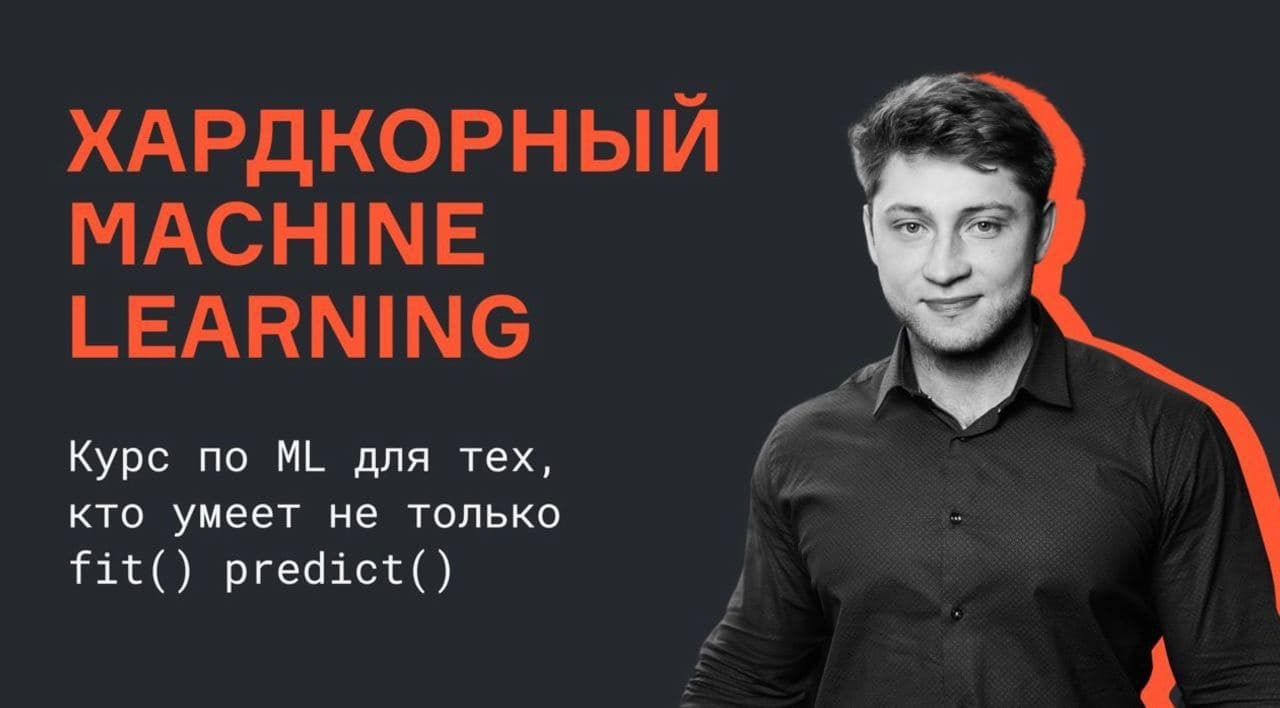
https://karpov.courses/ml-hard 

###Промокод CLUSTER, даёт 15% скидки как на полную, так и на поэтапную оплату


#Time Series Clustering: Зачем, кому, и как? 


Анализ и предсказание временных рядов — коварная штука: сегодня вы предсказываете один ряд, завтра вас могут попросить предсказать ещё 10, послезавтра — 100, потом — 200, а через некоторое время вы начинаете предсказывать уже тысячи рядов. Много ли это? Например, количество всех тикеров, взятых с Yahoo Finance, ровно 2762*. Попробуйте найти в них общие паттерны.

Если это число все же кажется вам небольшим, то теперь представьте, что у вас есть сеть, которая продаёт определённые товары в определённых магазинах. Скажем, небольшая сеть из 3000 магазинов и такой же небольшой ассортимент из 10 тысяч товаров. Сколько теперь получается рядов? Верно — 30 миллионов… А что если мы хотим узнать, какие из них продаются одинаково и какие есть паттерны, связанные с сезонностью? Как их можно объединить в группы и можно ли вообще это сделать? Вопросов много, а понимания, что со всем этим делать, нет.

Таким образом, кластеризация временных рядов — не простой, но очень интересный процесс, о котором мы поговорим в рамках вебинара.


В целом кластеризацию временных рядов можно разбить на 2 вида: 
 - Feature based подход, когда мы пытаемся вытащить все что только можно из сигнала/временного ряда
 - Raw-data based подход, непосредственно применяется к векторам временного ряда без каких-либо пространственных преобразований



На вебинаре разберём три вида объединений:

● В лоб с помощью старого доброго KMeans

● Более хитро через Dynamic Time Warping

● По харду, как взрослые люди, через Time Series Embeddings


In [2]:
!pip install tslearn

     |████████████████████████████████| 793 kB 7.7 MB/s 


In [4]:
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import yfinance as yf

'1.19.5'

In [ ]:
import yahoo_fin.stock_info as si
sp500 = si.tickers_sp500()

In [ ]:
len(sp500)

505

In [ ]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [ ]:
snp500 = []
tiker_list = np.random.choice(sp500, size=50)

for ticker in tqdm(tiker_list):
    try:
        ticker_obj = yf.Ticker(ticker)
        close_price = ticker_obj.history(period='6mo')['Close'].to_dict()
        info = get_info(ticker_obj)
        info.update(close_price)
        snp500.append(info)
    except:
        continue
        
snp500 = pd.DataFrame(snp500)

In [ ]:
snp500.dropna(axis=1, how='all', inplace=True)

In [ ]:
snp500

shortName  ... 2021-07-28 00:00:00
0     Boston Scientific Corporation  ...           45.430000
1            Home Depot, Inc. (The)  ...          325.519989
2                      DexCom, Inc.  ...          459.920013
3                       DaVita Inc.  ...          118.839996
4                      Allegion plc  ...          135.589996
5               Cisco Systems, Inc.  ...           54.770000
6        Penn National Gaming, Inc.  ...           72.080002
7          Franklin Resources, Inc.  ...           29.200001
8     American Airlines Group, Inc.  ...           21.629999
9         Arthur J. Gallagher & Co.  ...          137.509995
10  Automatic Data Processing, Inc.  ...          206.880005
11     Northrop Grumman Corporation  ...          360.109985
12  American Tower Corporation (REI  ...          284.980011
13             McKesson Corporation  ...          204.160004
14                  Fox Corporation  ...           36.320000
15                    Moderna, Inc.  ...          349.320007
16        Walt Disney Company (The)  ...          179.100006
17              Moody's Corporation  ...          378.579987
18  J.B. Hunt Transport Services, I  ...          164.490005
19          Republic Services, Inc.  ...          115.349998
20                Cigna Corporation  ...          227.250000
21            Gilead Sciences, Inc.  ...           70.059998
22                   L Brands, Inc.  ...           77.430000
23        Consolidated Edison, Inc.  ...           74.589996
24        TJX Companies, Inc. (The)  ...           67.879997
25                  Globe Life Inc.  ...           93.139999
26                  BorgWarner Inc.  ...           47.700001
27       Penn National Gaming, Inc.  ...           72.080002
28                      DaVita Inc.  ...          118.839996
29             Baker Hughes Company  ...           21.000000
30              FIRST REPUBLIC BANK  ...          197.619995
31  TE Connectivity Ltd. New Switze  ...          141.929993
32                       Nike, Inc.  ...          165.460007
33  Huntington Bancshares Incorpora  ...           13.990000
34    Progressive Corporation (The)  ...           94.519997
35         Marathon Oil Corporation  ...           11.780000
36  D/B/A Royal Caribbean Cruises L  ...           80.089996
37   United Airlines Holdings, Inc.  ...           49.139999
38                Loews Corporation  ...           53.250000
39              Halliburton Company  ...           21.090000
40             Clorox Company (The)  ...          181.710007
41        Eversource Energy (D/B/A)  ...           86.379997
42             ConAgra Brands, Inc.  ...           33.759998
43                     DexCom, Inc.  ...          459.920013
44            JP Morgan Chase & Co.  ...          151.699997
45  The Bank of New York Mellon Cor  ...           50.349998
46              Chevron Corporation  ...          101.180000
47                    MetLife, Inc.  ...           57.639999
48      Caesars Entertainment, Inc.  ...           92.370003
49                     AMETEK, Inc.  ...          136.869995

[50 rows x 129 columns]

In [ ]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(snp500.iloc[:, 5:].T).T

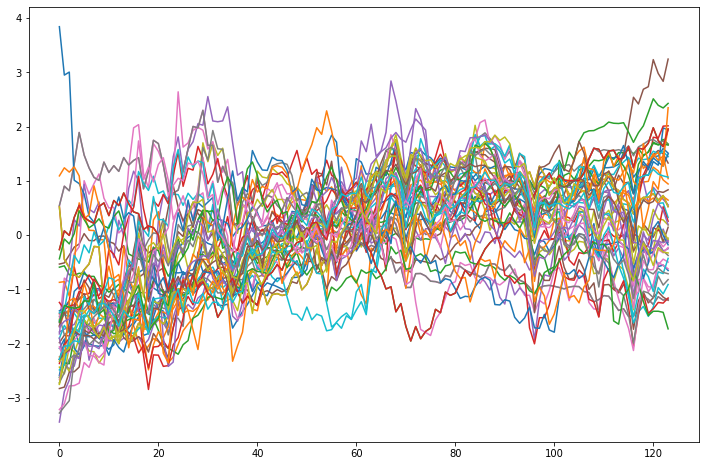

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(tickers_scaled.T)

# Basik KMeans

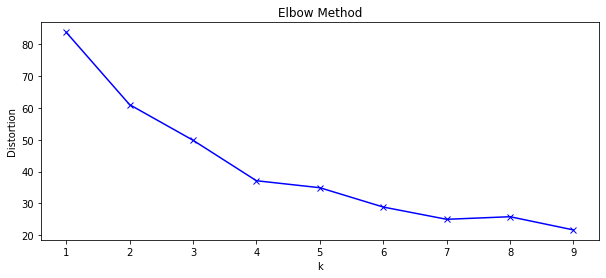

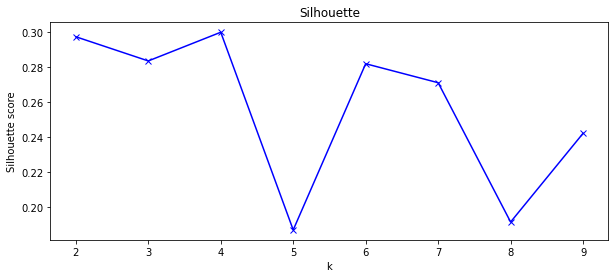

In [ ]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [ ]:
n_clusters = 6
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=10,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=6, n_init=1, n_jobs=3,
                 random_state=None, tol=1e-06, verbose=0)

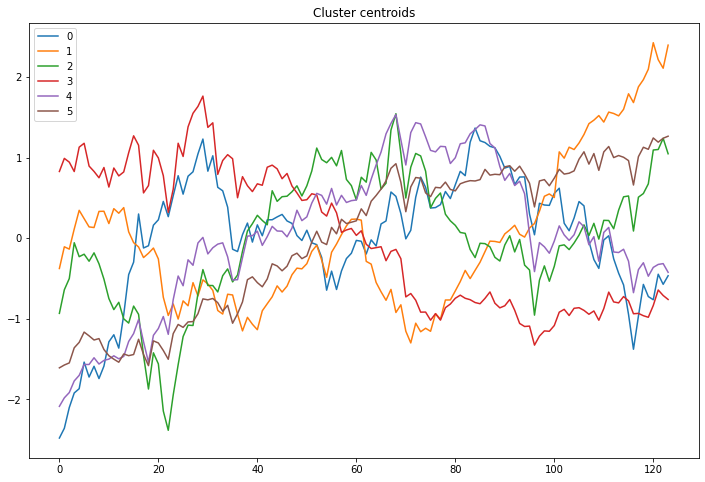

In [ ]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [ ]:
snp500['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(snp500.groupby('cluster')['sector'].value_counts())

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries



sector
cluster sector                        
0       Energy                       4
        Consumer Cyclical            2
        Industrials                  2
        Communication Services       1
        Financial Services           1
1       Healthcare                   3
        Consumer Cyclical            1
2       Consumer Cyclical            2
        Healthcare                   1
        Utilities                    1
3       Consumer Cyclical            2
        Communication Services       1
        Consumer Defensive           1
4       Financial Services           6
        Consumer Cyclical            1
        Consumer Defensive           1
        Healthcare                   1
        Industrials                  1
        Utilities                    1
5       Industrials                  5
        Financial Services           4
        Healthcare                   4
        Technology                   2
        Consumer Cyclical            1
        Real Estate                  1

In [ ]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


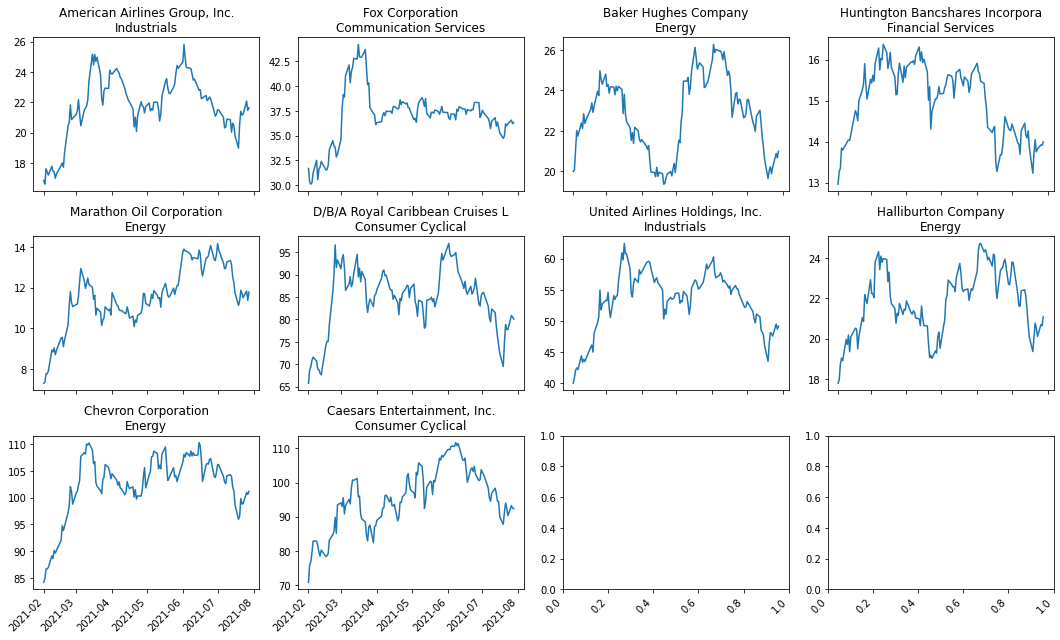

                          Cluster number: 1


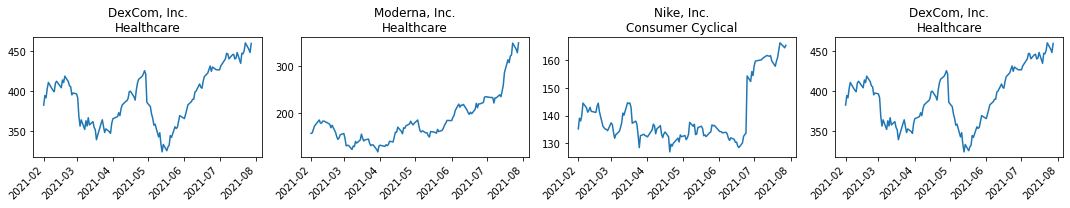

                          Cluster number: 2


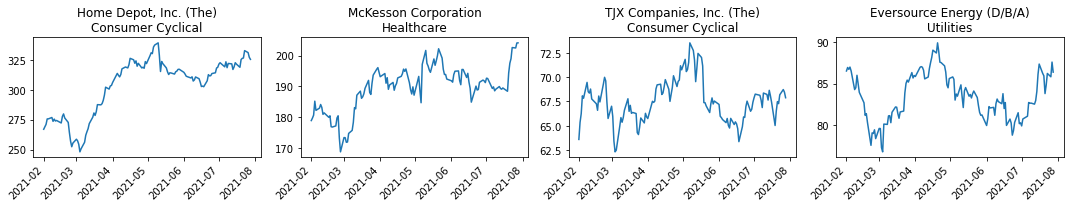

                          Cluster number: 3


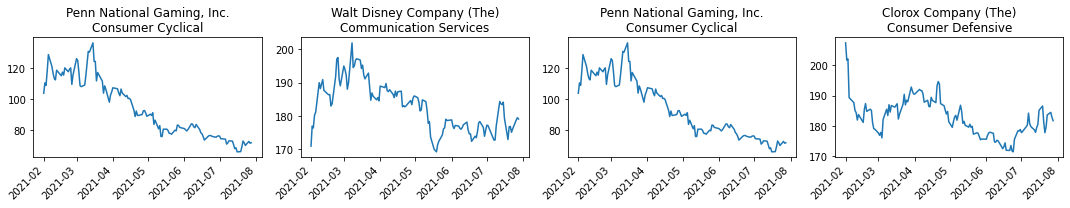

                          Cluster number: 4


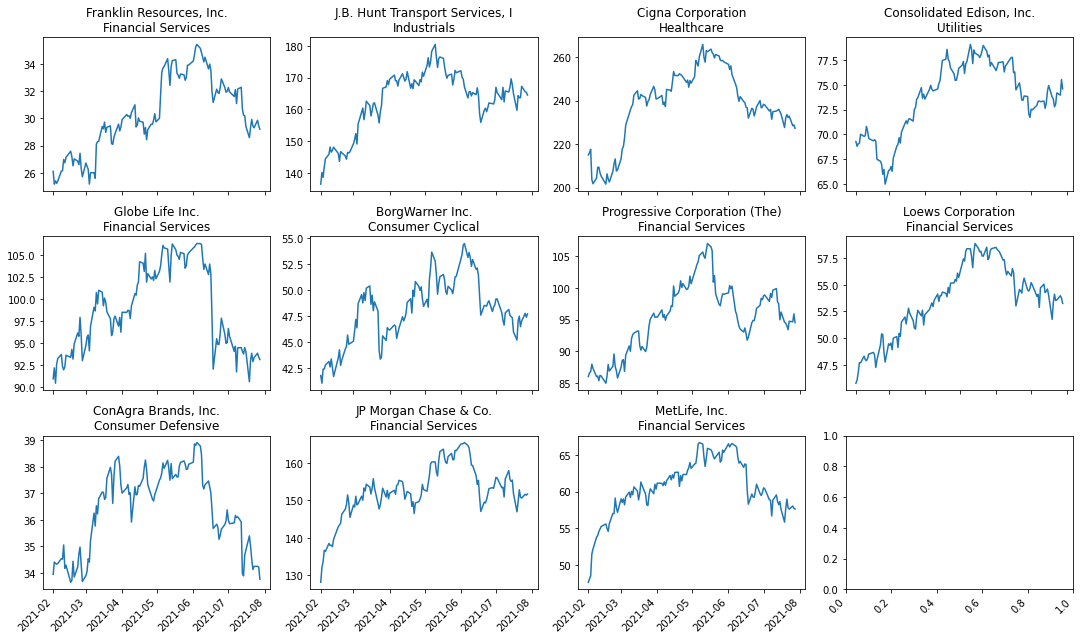

                          Cluster number: 5


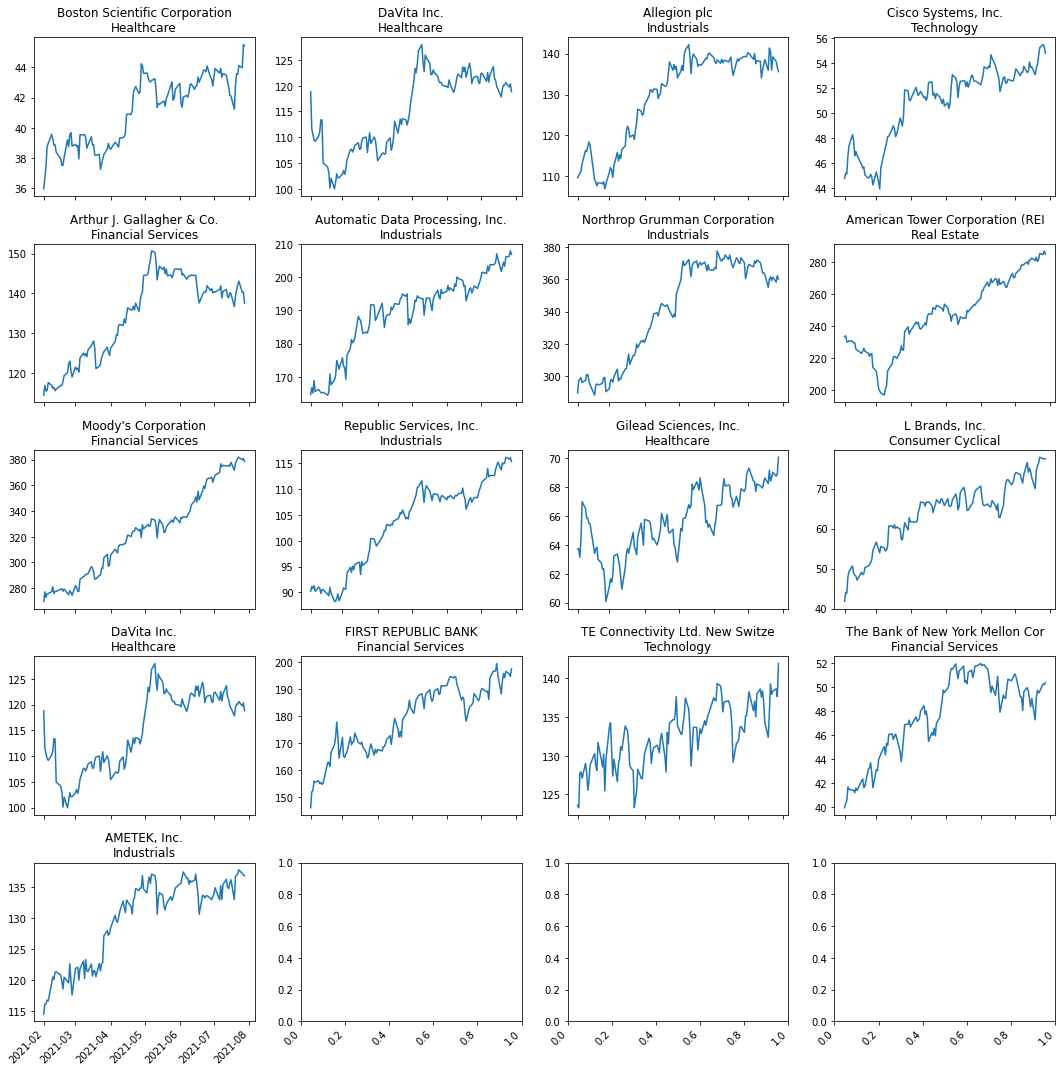

In [ ]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(snp500[snp500.cluster==cluster])

### DTW

$$DTW(x, y) = min_{\pi} \sqrt{\sum_{(i,j)\in \pi} d(x_i, y_j)^2},$$

где $\pi = [\pi_0, ..., \pi_K]$ - это путь, удовлетворяющий набору условий:
 - это лист парных индексов $\pi_k = (i_k, j_k)$, где  $0 \leq i_k \lt n$ и $0 \leq j_k \lt m $;
 -  $\pi_0 = (0, 0)$ и $\pi_K = (n-1, m-1)$
для всех $k\gt0$,
 - $\pi_k=(i_k, j_k)$ и $\pi_{k-1}=(i_{k-1}, j_{k-1})$ удовлетворяют следующим неравенствам:
- $i_{k-1} \leq i_k \leq i_{k-1} + 1$
- $j_{j-1} \leq j_k \leq j_{k-1} + 1$


А если по-человечески:
- Путь - это индексы временных рядов
- Путь может ходить по диагонали, горизонтали и вертикали, 
главное, чтобы был неубывающим по индексам
- Стартуем всегда в начале временных рядов, заканчиваем всегда в конце


https://upload.wikimedia.org/wikipedia/commons/8/84/Animation_Dynamic_Time_Warping.gif

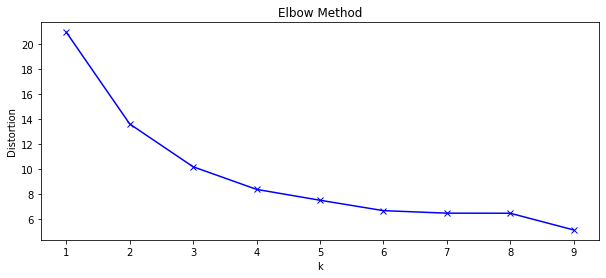

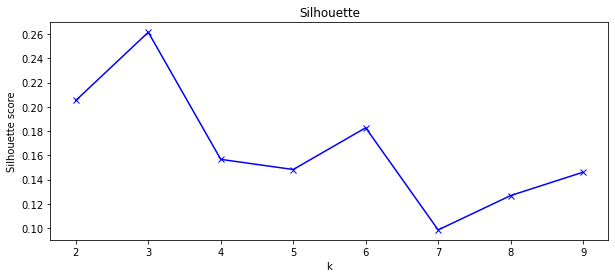

In [ ]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [ ]:
n_clusters = 6
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=10,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=6, n_init=1, n_jobs=6, random_state=None, tol=1e-06,
                 verbose=0)

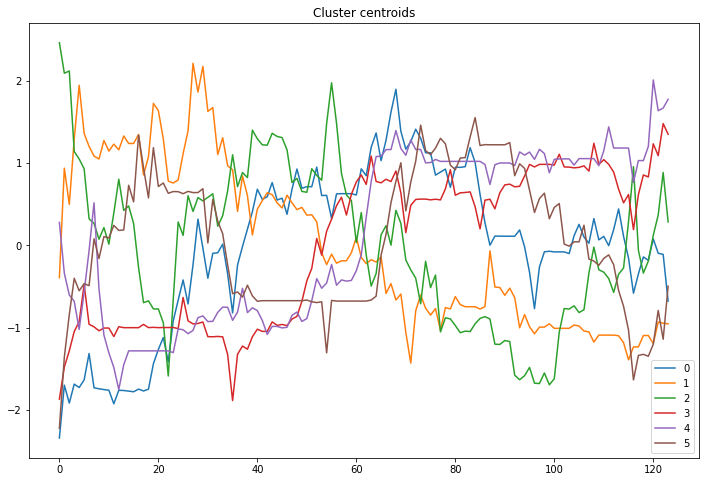

In [ ]:
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")

plt.legend()
plt.show()

In [ ]:
snp500['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(snp500.groupby('cluster')['sector'].value_counts())

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning:

2-Dimensional data passed. Assuming these are 50 1-dimensional timeseries



sector
cluster sector                        
0       Financial Services           5
        Consumer Cyclical            3
        Communication Services       1
        Consumer Defensive           1
        Energy                       1
        Healthcare                   1
        Industrials                  1
        Utilities                    1
1       Consumer Cyclical            2
        Communication Services       1
2       Consumer Defensive           1
        Utilities                    1
3       Industrials                  5
        Financial Services           4
        Healthcare                   3
        Consumer Cyclical            2
        Technology                   2
        Real Estate                  1
4       Healthcare                   5
        Consumer Cyclical            1
5       Energy                       3
        Financial Services           2
        Industrials                  2
        Consumer Cyclical            1

                          Cluster number: 0


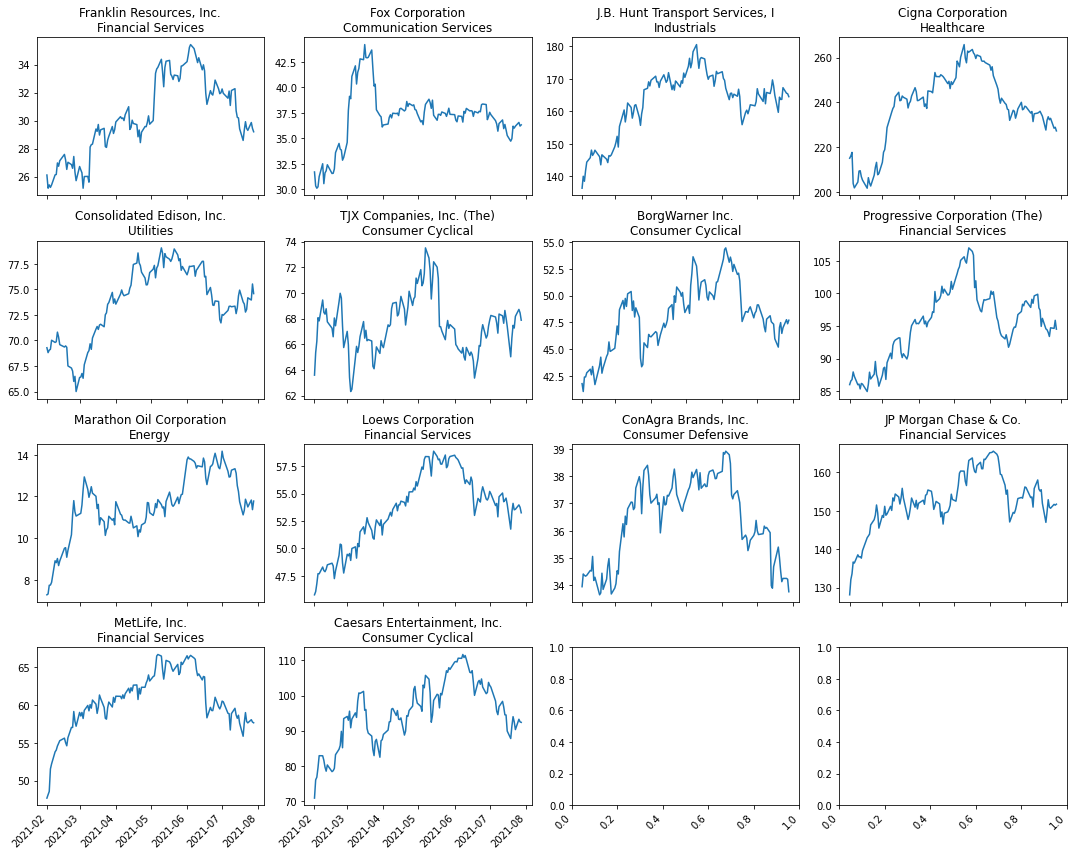

                          Cluster number: 1


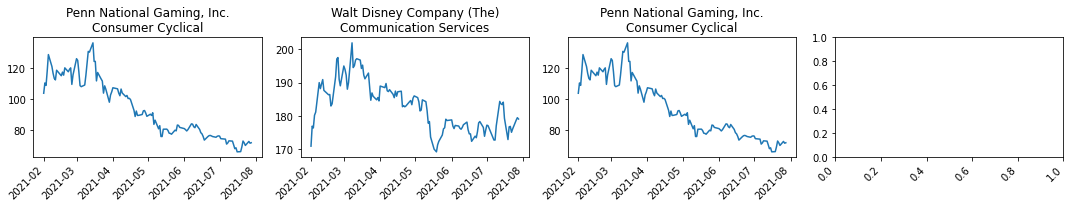

                          Cluster number: 2


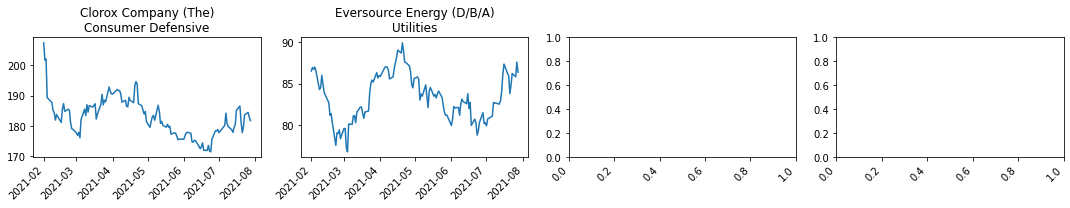

                          Cluster number: 3


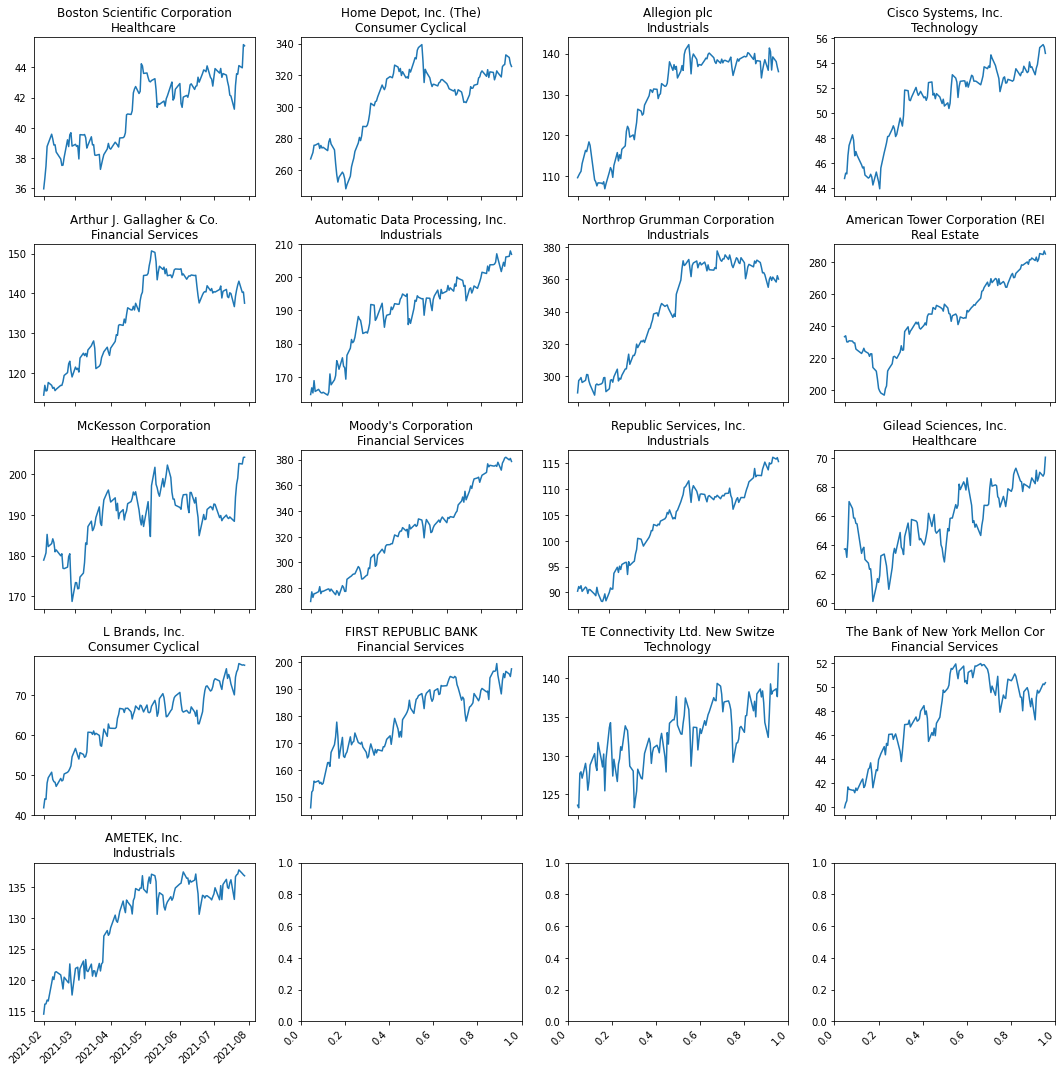

                          Cluster number: 4


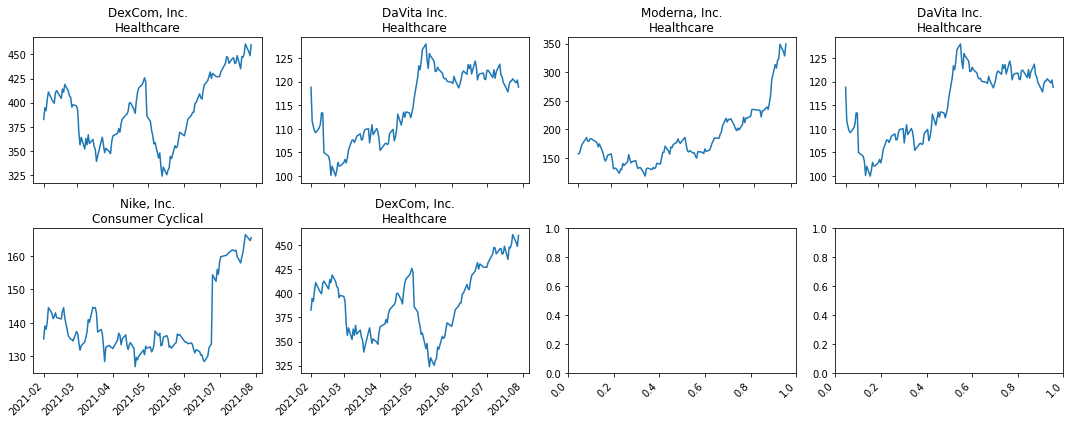

                          Cluster number: 5


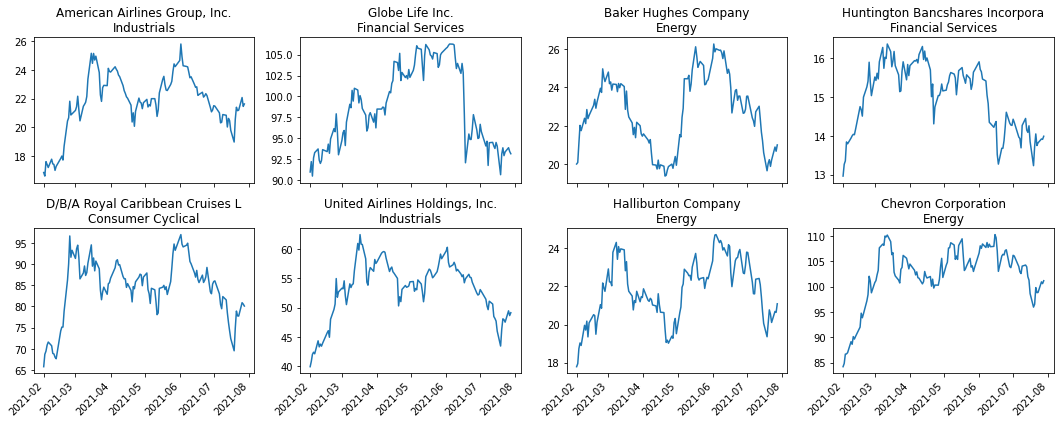

In [ ]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(snp500[snp500.cluster==cluster])

## VRAE

Timeseries clustering is an unsupervised learning task aimed to partition unlabeled timeseries objects into homogenous groups/clusters. Timeseries in the same cluster are more similar to each other than timeseries in other clusters

This algorithm is able to:

- Identify joint dynamics across the sequences
- Eliminate lags (time-shifts) across sequences (usually called lag-invariance)
- Generate features which are interpretable.

In general, timeseries clustering algorithms are of two types:

 - Feature based - transform raw data using feature extraction, run clustering on top of generated features
 - Raw-data based - directly applied over timeseries vectors without any space-transformations


VRAE is a feature-based timeseries clustering algorithm, since raw-data based approach suffers from curse of dimensionality and is sensitive to noisy input data. The middle bottleneck layer will serve as the feature representation for the entire input timeseries.

In [ ]:
tickers_scaled.shape

(50, 124)

In [ ]:
! git clone https://github.com/tejaslodaya/timeseries-clustering-vae.git

Cloning into 'timeseries-clustering-vae'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 106 (delta 4), reused 1 (delta 0), pack-reused 92
Receiving objects: 100% (106/106), 3.94 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
from timeseries_clustering_vae.vrae.vrae import VRAE
from timeseries_clustering_vae.vrae.utils import *
import numpy as np
import torch

import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

In [ ]:
dload = '/content/timeseries_clustering_vae/' #download directory

In [ ]:
hidden_size = 50
hidden_layer_depth = 1
latent_length = 20
batch_size = 5
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.1
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

In [ ]:
def prepare_data(tiker_scaled_df, ratio_train=0.9):
    """Input:
    direc: location of the UCR archive
    ratio_train: ratio to split training and testset
    dataset: name of the dataset in the UCR archive"""

    data = tiker_scaled_df
    # data = np.concatenate((data_train, data_test_val), axis=0)
    data = np.expand_dims(data, -1)
    

    N, D, _ = data.shape

    ind_cut = int(ratio_train * N)
    ind = np.random.permutation(N)
    return data[ind[:ind_cut], :, :], data[ind[ind_cut:], :, :], np.zeros(shape=(45,1)), np.zeros(shape=(45,1))

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(tickers_scaled, ratio_train=0.9)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
y_val -= base

In [ ]:
print(X_train.shape, X_val.shape)

(45, 124, 1) (5, 124, 1)


In [ ]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_val))

In [ ]:
sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

In [ ]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



In [ ]:
vrae.fit(train_dataset)

In [ ]:
z_run = vrae.transform(test_dataset)

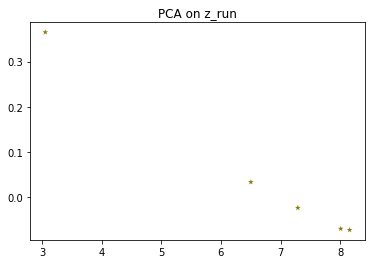

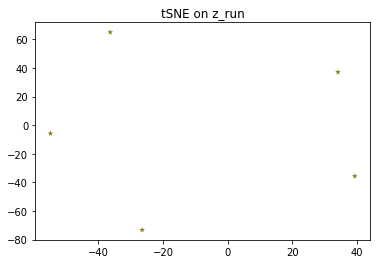

In [ ]:
plot_clustering(z_run, y_val, engine='matplotlib', download = False)

### Variational Recurrent Auto-encoders (VRAE) Vanila

In [ ]:
X_train, X_val, y_train, y_val = open_data(dload + 'data', ratio_train=0.9)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
y_val -= base

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_val))

In [ ]:
sequence_length = X_train.shape[1]

In [ ]:
number_of_features = X_train.shape[2]

In [ ]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 32
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

In [ ]:
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



In [ ]:
vrae.fit(train_dataset)

In [ ]:
z_run = vrae.transform(test_dataset)

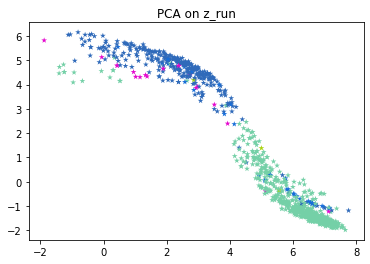

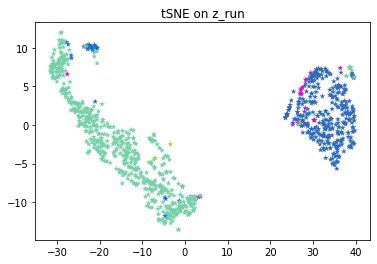

In [ ]:
plot_clustering(z_run, y_val, engine='matplotlib', download = False)

## DeepTemporalClustering

In [ ]:
! git clone https://github.com/FlorentF9/DeepTemporalClustering.git

Cloning into 'DeepTemporalClustering'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (59/59), done.


In [ ]:
! python3 DeepTemporalClustering/DeepTemporalClustering.py --help

2021-07-29 08:53:23.817254: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
usage: DeepTemporalClustering.py [-h] [--dataset DATASET]
                                 [--ae_weights AE_WEIGHTS]
                                 [--n_clusters N_CLUSTERS]
                                 [--n_filters N_FILTERS]
                                 [--kernel_size KERNEL_SIZE]
                                 [--strides STRIDES] [--pool_size POOL_SIZE]
                                 [--n_units N_UNITS N_UNITS] [--gamma GAMMA]
                                 [--alpha ALPHA]
                                 [--dist_metric {eucl,cid,cor,acf}]
                                 [--cluster_init {kmeans,hierarchica

## Time2Vec for Time Series features encoding

https://towardsdatascience.com/time2vec-for-time-series-features-encoding-a03a4f3f937e

https://arxiv.org/abs/1907.05321

https://github.com/email81227/Time2Vec-TensorFlow2

## Encoder-Decoder Model for Multistep Time Series Forecasting

https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://github.com/gautham20/pytorch-ts